image_datasets['train'] = Dataset ImageFolder
    Number of datapoints: 1299
    Root location: training_dataset\train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
               ColorJitter(brightness=None, contrast=None, saturation=None, hue=None)
               CenterCrop(size=(64, 64))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
image_datasets['val'] = Dataset ImageFolder
    Number of datapoints: 1292
    Root location: training_dataset\val
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               ToTensor()
        

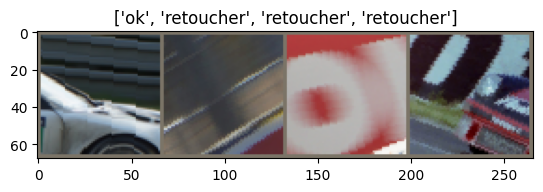

Epoch 0/49
----------
train Loss: 1.2205 Acc: 0.6343
val Loss: 1.2689 Acc: 0.7121

Epoch 1/49
----------
train Loss: 0.8879 Acc: 0.6813
val Loss: 1.7407 Acc: 0.7121

Epoch 2/49
----------
train Loss: 0.8271 Acc: 0.6998
val Loss: 1.2252 Acc: 0.7167

Epoch 3/49
----------
train Loss: 0.7948 Acc: 0.7105
val Loss: 1.1529 Acc: 0.6780

Epoch 4/49
----------
train Loss: 0.7435 Acc: 0.7175
val Loss: 0.8913 Acc: 0.7144

Epoch 5/49
----------
train Loss: 0.7415 Acc: 0.7021
val Loss: 1.1856 Acc: 0.7121

Epoch 6/49
----------
train Loss: 0.6901 Acc: 0.7306
val Loss: 1.5391 Acc: 0.3467

Epoch 7/49
----------
train Loss: 0.6087 Acc: 0.7606
val Loss: 0.9850 Acc: 0.6935

Epoch 8/49
----------
train Loss: 0.5726 Acc: 0.7768
val Loss: 0.9277 Acc: 0.7221

Epoch 9/49
----------
train Loss: 0.5853 Acc: 0.7621
val Loss: 0.9547 Acc: 0.6935

Epoch 10/49
----------
train Loss: 0.5739 Acc: 0.7760
val Loss: 0.8508 Acc: 0.7221

Epoch 11/49
----------
train Loss: 0.5655 Acc: 0.7706
val Loss: 0.9072 Acc: 0.7090

Ep

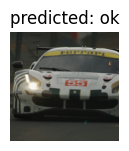

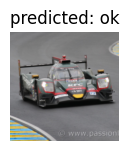

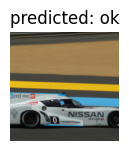

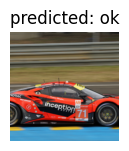

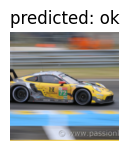

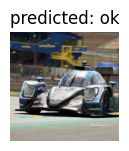

In [5]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

cudnn.benchmark = True
plt.ion()   # interactive mode

# Data augmentation and normalization for training  
# Just normalization for validation

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=30),
        transforms.ColorJitter(),
#        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=64),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'training_dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
print (f"image_datasets['train'] = {image_datasets['train']}")
print (f"image_datasets['val'] = {image_datasets['val']}")
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
print (f"dataloaders['train'] = {dataloaders['train']}")
print (f"dataloaders['val'] = {dataloaders['val']}")
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

model_ft = models.vgg16(pretrained=True)
num_ftrs = model_ft.classifier[6].in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 3)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50)

torch.save(model_ft, 'model_ftV5.pth')

visualize_model(model_ft)

plt.ioff()
plt.show()

In [4]:
torch.save(model_ft.state_dict(), 'model_custom_weightsV5.pth')

In [ ]:
print(class_names)

['exclure', 'ok', 'retoucher']


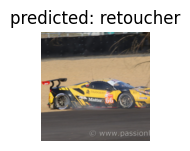

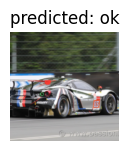

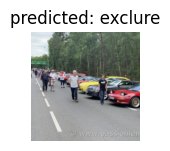

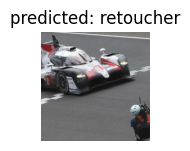

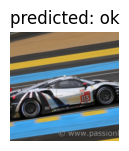

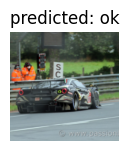

In [3]:
visualize_model(model_ft)

plt.ioff()
plt.show()